# 1. Import data

- import libraries

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- Import data

In [273]:
df = pd.read_csv('/content/drive/MyDrive/Fiverr/Client 7 - Lisa/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# 2. Explore data

- Select the columns of interest

In [267]:
columns = ['neighbourhood','price']
df = df[columns]
df.head()

,neighbourhood,price
0,Kensington,149
1,Midtown,225
2,Harlem,150
3,Clinton Hill,89
4,East Harlem,80


- isna

In [268]:
df.isna().sum()

neighbourhood    0
price            0
dtype: int64

- Count

In [114]:
df.neighbourhood.value_counts()

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Fort Wadsworth           1
Richmondtown             1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: neighbourhood, Length: 221, dtype: int64

- Num neighboorhoods

In [115]:
len(df.neighbourhood.unique())

221

- Distribution of prices

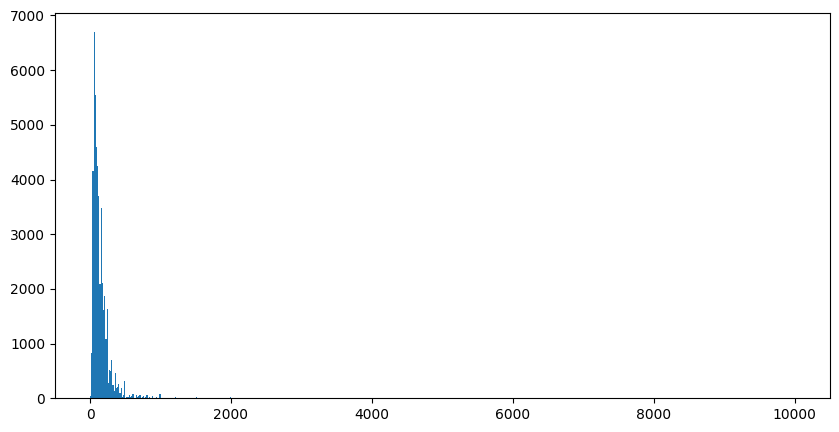

In [269]:
plt.figure(figsize = (10,5))
plt.hist(df.price,bins = 600)
plt.show()

# 3. Process data

## Fix prices

In order to have meaningful results we must deletd every price that is 0, since in reality, no house costs 0 and its more likely they are outliers then actual data

In [274]:
other_than_0_mask = df.price != 0

In [275]:
df = df[other_than_0_mask]

Our results are actually pretty skewed. In order to have more interesting results, let's apply a log transformation to our data

48884

In [278]:
original_price = df['price']
df['price'] = np.log(df['price'])

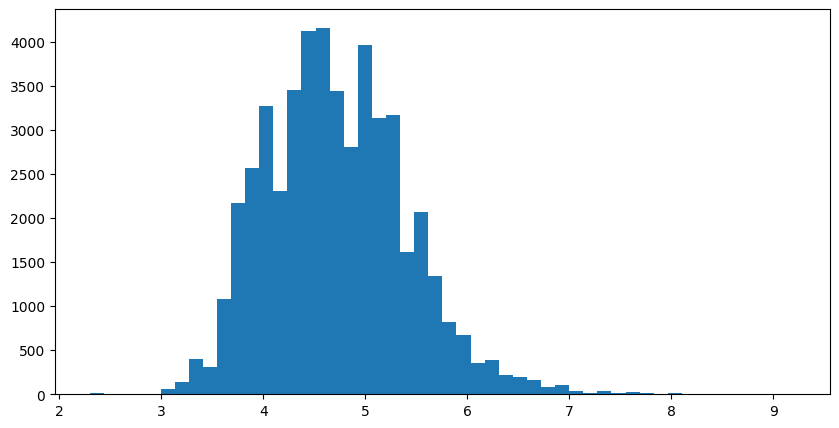

In [279]:
plt.figure(figsize = (10,5))
plt.hist(df.price,bins = 50)
plt.show()

## Encode the neighbourhood data

Like many Unsupervised Learning Algorithms, it's essential to ensure that our input data is entirely numeric. In our dataset, the only categorical data pertains to neighborhoods. To address this, we will employ a technique known as target encoding. Target encoding strives to transform categorical data by incorporating information from the target variable it aims to predict. Although our primary goal may not be predicting price based on neighborhood, this method can effectively encode the data while still capturing any existing relationship between the two variables.

- Target Encoding

In [280]:
data_encoded = pd.DataFrame()
data_encoded['price'] = df['price']

means = df.groupby('neighbourhood')['price'].mean().to_dict()
data_encoded['neighbourhood_encoded'] = df['neighbourhood'].map(means)

- Remove Outliers

In [281]:
from sklearn.covariance import EllipticEnvelope

pred_eliptic = EllipticEnvelope(contamination=0.1).fit(data_encoded).predict(data_encoded)
outlier_mask = pred_eliptic == -1
data_encoded = data_encoded[~outlier_mask]


In [284]:
len(data_encoded)

43995

- Standardization

Standardization is a data preprocessing technique in statistics and machine learning that transforms numerical data to have a mean of zero and a standard deviation of one. It involves subtracting the mean of the data from each data point and then dividing by the standard deviation.

In [288]:
from sklearn.preprocessing import StandardScaler

# Standardize the 'price' column
scaler = StandardScaler()
data_standarized = scaler.fit_transform(data_encoded)


- Scatter plot to visualize results

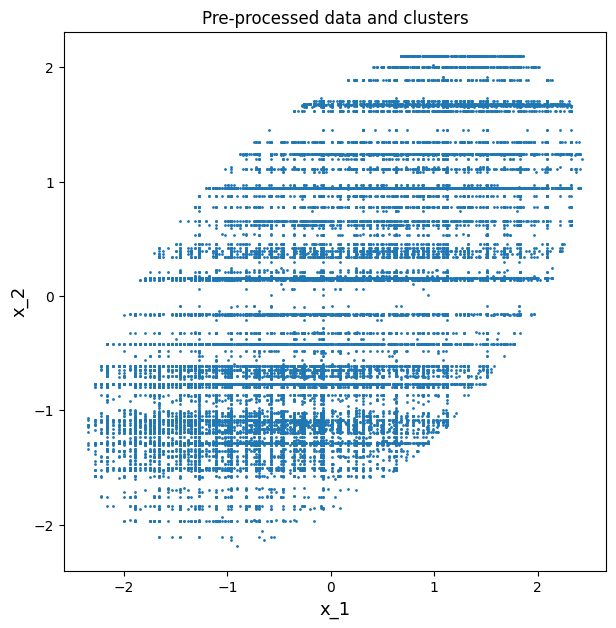

In [248]:
def plot_data(data,labels):

  # Plot the clusters in two dimensions
  x1 = data[:,0]
  x2 = data[:,1]

  plt.figure(figsize = (7,7))
  plt.scatter(x1, x2,
              c = labels,
              s = 1)

  plt.title('Pre-processed data and clusters')
  plt.xlabel("x_1",fontsize = 13)
  plt.ylabel("x_2",fontsize = 13)
  plt.show()

plot_data(data_standarized,None)

# 4. Model

The silhouette score is a metric used to evaluate the performance of clustering algorithms. It measures how well each data point fits into its assigned cluster, based on both the distance between the point and other points in the same cluster (intra-cluster distance) and the distance between the point and points in other clusters (inter-cluster distance)

- Function to evaluate score

In [183]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def labels_prop(labels):
  return pd.Series(labels).value_counts()

def score(data,labels):
  # Calculate silhouette score
  silhouette_avg = silhouette_score(data, labels)
  print("Silhouette Score: {:.4f}".format(silhouette_avg))

  print(labels_prop(labels))



## Kmeans

K-Means is a popular unsupervised machine learning algorithm used for clustering similar data points into groups or clusters. Here's a brief overview:

Objective: The main goal of K-Means is to partition a dataset into K distinct, non-overlapping clusters, where each data point belongs to the cluster with the nearest mean (centroid).

In [129]:
from sklearn.cluster import KMeans

# Initialize the k-means model with the desired number of clusters (k)
kmeans = KMeans(n_clusters = 3)

# Fit the model to the data in the dataframe
kmeans.fit(data_standarized)

# Get the labels for each row in the dataframe
labels = kmeans.predict(data_standarized)

score(data_standarized,labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.3798
1    15697
2    14812
0    13486
dtype: int64


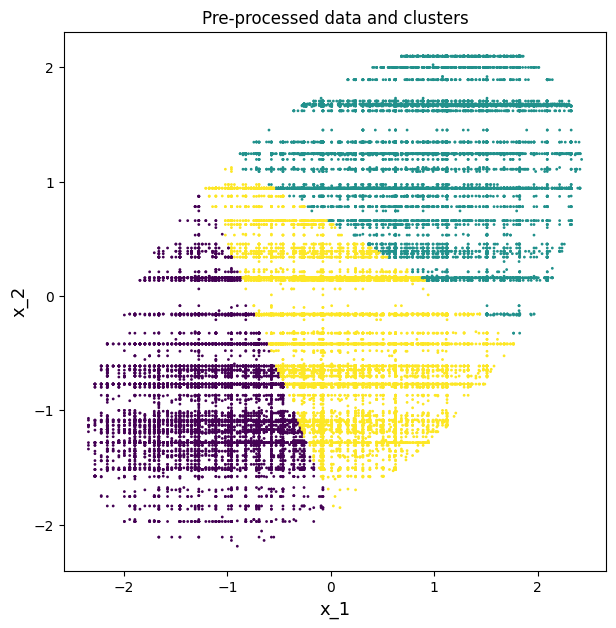

In [130]:
plot_data(data_standarized,labels)

## DBSCAN

- Model

In [142]:
from sklearn.cluster import DBSCAN

# Assuming you have your data standardized and combined as X_combined
# If not, please refer to the previous responses for data preprocessing

# Create a DBSCAN model
dbscan = DBSCAN(eps=0.1, min_samples=5)  # You can adjust eps and min_samples as needed

# Fit the model to your data
clusters = dbscan.fit_predict(data_standarized)

# Check the number of clusters found by DBSCAN
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f'Number of clusters found by DBSCAN: {n_clusters}')
print(f'Number of noise points: {n_noise}')
score(data_standarized,clusters)

Number of clusters found by DBSCAN: 14
Number of noise points: 45
Silhouette Score: -0.0500
 0     22119
 2     14738
 3      2603
 4      2514
 1      1373
 6       515
-1        45
 12       19
 7        18
 8        16
 13       12
 5         6
 9         6
 10        6
 11        5
dtype: int64


100%|██████████| 99/99 [01:06<00:00,  1.48it/s]


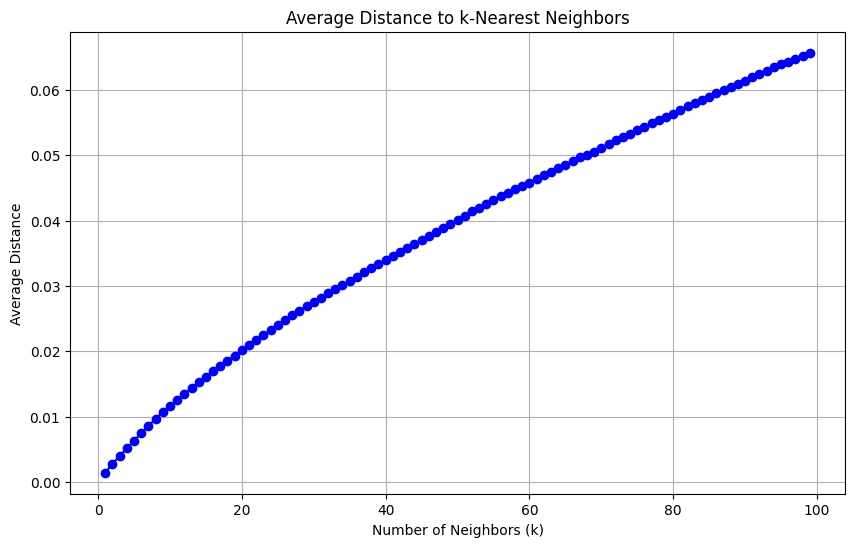

In [140]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# Fit a k-nearest neighbors model to your data
k_values = range(1, 100)  # You can adjust the range as needed
distances = []

for k in tqdm(k_values):
    neighbors_model = NearestNeighbors(n_neighbors=k)
    neighbors_model.fit(data_standarized)
    avg_distances, _ = neighbors_model.kneighbors()
    distances.append(np.mean(avg_distances[:, -1]))

# Plot the average distances for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, distances, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Distance')
plt.title('Average Distance to k-Nearest Neighbors')
plt.grid(True)
plt.show()


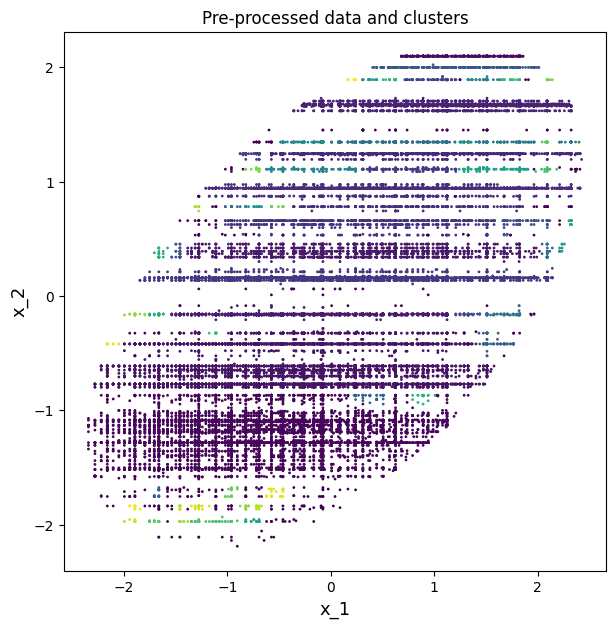

In [132]:
plot_data(data_standarized,clusters)

## Gaussian Mixture model

A Gaussian Mixture Model (GMM) is a probabilistic model used in statistics and machine learning. It represents a dataset as a combination of multiple Gaussian distributions, each associated with a specific cluster or component. GMMs are employed for tasks such as clustering and density estimation. They capture complex data patterns by modeling the underlying probability distribution as a mixture of simpler Gaussian distributions, allowing them to handle datasets with non-uniform shapes and varying densities effectively. GMMs are characterized by parameters like means, variances, and mixing coefficients, which are estimated from the data through methods like the Expectation-Maximization (EM) algorithm.






In [290]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture

# Assuming 'neighbourhood' and 'price' are your feature columns

# Initialize and fit the GMM model
n_clusters = 7  # You can specify the number of clusters you want
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(data_standarized)

# Predict cluster assignments
cluster_assignments = gmm.predict(data_standarized)

# You can access the means and covariances of each cluster like this:
cluster_means = gmm.means_
cluster_covariances = gmm.covariances_

# You can explore the results or visualize the clusters as needed
score(data_standarized,cluster_assignments)

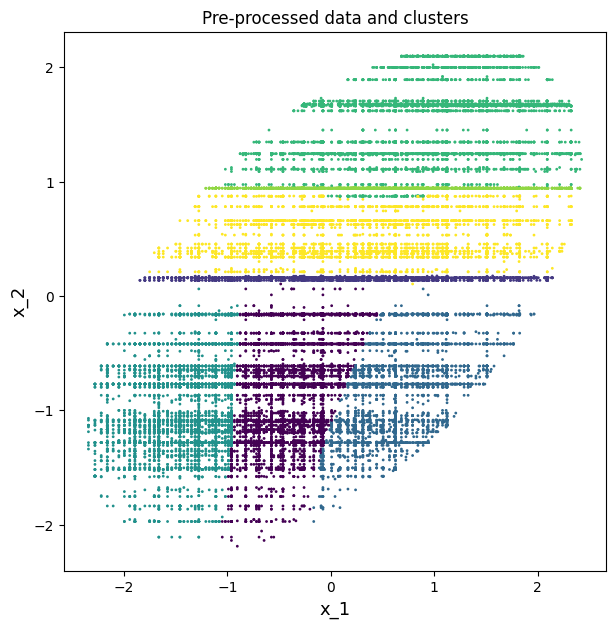

In [253]:
plot_data(data_standarized,cluster_assignments)

- Best number of clusters

To determine the optimum number of clusters a good technique is to test for many clusters and storet a score. In this specific case, the BIC score is more appropriate.

The Bayesian Information Criterion (BIC) is a measure used in Gaussian Mixture Models (GMMs) to find the best number of clusters. It balances model fit and complexity by penalizing complex models. In GMMs, lower BIC scores indicate a better trade-off between model fit and simplicity, helping select the right number of clusters for the data.

100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


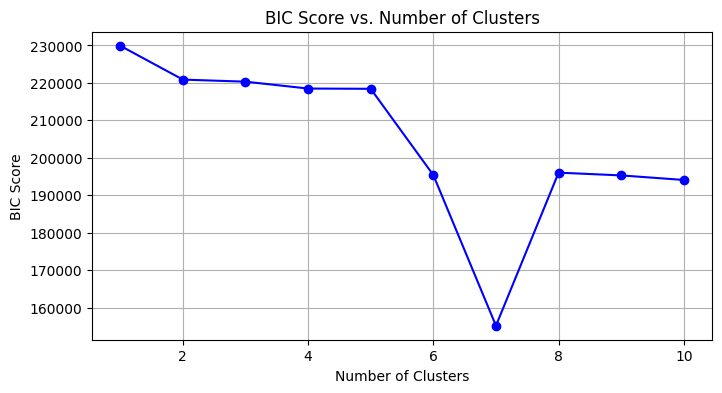

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
# Assuming you have your data in 'features'
# Fit GMM with a range of cluster numbers
num_clusters = range(1, 11)
bic_scores = []

for n in tqdm(num_clusters):
    gmm = GaussianMixture(n_components=n)
    gmm.fit(data_standarized)
    bic_scores.append(gmm.bic(data_standarized))

# Plot the BIC scores
plt.figure(figsize=(8, 4))
plt.plot(num_clusters, bic_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Clusters')
plt.grid(True)
plt.show()


The sudden drop in the BIC score at 7 clusters suggests that the model fits the data much better at 7 clusters than at 6 or 8 clusters . This could be due to the data having a natural clustering at 7 clusters, or it could be due to the model overfitting the data at 6 or 8 clusters .

# 5. Conclusion

While the Gaussian Mixture Model may not exhibit a particularly high silhouette score, it stands out as the most intriguing option among all the models. This is primarily due to its unique ability to demonstrate a substantial distinction when varying the number of clusters. This suggests that the model possesses the capability to identify inherent clusters within the data, an assertion supported by the relatively low BIC score associated with seven clusters when compared to other cluster numbers.

Based on these observations, we can confidently conclude that the GMM model, configured with seven clusters, yields the most favorable results among all the models considered.

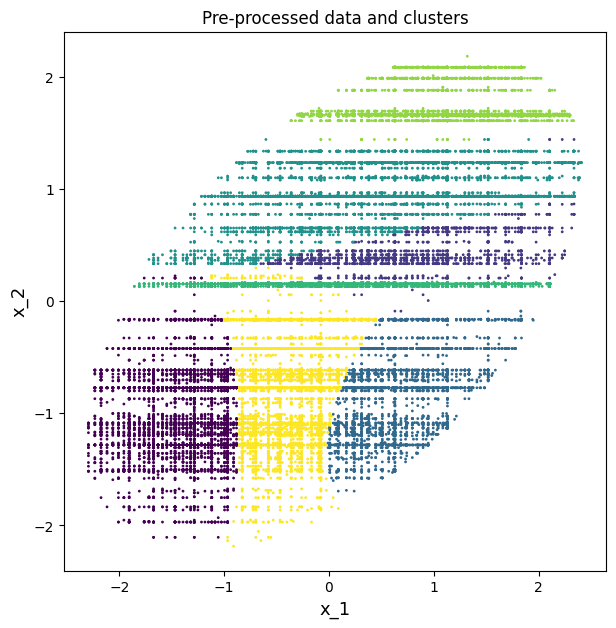

In [243]:
plot_data(data_standarized,cluster_assignments)

- Save results

In [ ]:
import pandas as pd

original_df = pd.read_csv('/content/drive/MyDrive/Fiverr/Client 7 - Lisa/AB_NYC_2019.csv')


# Create a new column 'Cluster' in the original dataset
original_df['Cluster'] = -1  # Initialize all rows with -1

# Assign clusters to the rows present in the final dataset
original_df.loc[data_encoded.index, 'Cluster'] = cluster_assignments

# Now, your original DataFrame has 'Cluster' values assigned, with -1 for deleted lines
original_df

In [296]:
original_df.to_csv('original_dataset_with_clusters.csv')